In [1]:
print("First we import our dependencies")

First we import our dependencies


In [5]:
from __future__ import print_function
#import torch
import codecs
import re
import datetime
#import matplotlib
import numpy as np
#import torch.functional as F
#import torch.nn.functional as F
import os
import pickle
#from torch.autograd import Variable
#from annoy import AnnoyIndex
#from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
#from matplotlib import pyplot

In [7]:
print("Next we import our global variables. We are going to run this on CPU and only our query set in the interest of time.")
#DEVICE = torch.device("cuda:0")
FILES = ['data/queries.dev.tsv','data/queries.eval.tsv']
#FILES = ['data/collection.tsv']
#FILES = ['data/queries.dev.tsv','data/queries.eval.tsv','data/queries.train.tsv','data/collection.tsv']
#DEVICE = torch.device("cpu")
EMBEDDING_DIMENSION = 50
EPOCHS = 2
MB_SIZE = 50000
VOCAB_SIZE = 10000 #Extra small to allow running on small computers
learning_rate = 1e-3
WINDOW = 4

regex_drop_char = re.compile('[^a-z0-9\s]+')
regex_multi_space = re.compile('\s+')

Next we import our global variables. We are going to run this on CPU and only our query set in the interest of time.


In [8]:
def print_message(s):
    print("[{}] {}".format(datetime.datetime.utcnow().strftime("%b %d, %H:%M:%S"), s), flush=True)

In [9]:
def generate_vocabulary():
    print_message('Converting MSMARCO files to corpus and building vocab')
    word_count = {}
    word_count['<UNK>'] = 1
    corpus_length = 0
    for a_file in FILES:
        print_message("Loading file {}".format(a_file))
        with codecs.open(a_file,'r', encoding='utf-8') as f:
            for l in f:
                l = l.strip().split('\t')
                if len(l) > 1:
                    l = l[1]
                else:
                    l = l[0]
                for word in regex_multi_space.sub(' ', regex_drop_char.sub(' ', l.lower())).strip().split():
                    if word not in word_count:
                        word_count[word] = 0
                    word_count[word] += 1
                    corpus_length += 1
    print_message('Done reading vocab.There are {} unique words and the corpus is {} words long'.format(len(word_count), corpus_length))
    return word_count

In [10]:
print("The function above reads through our files, cleans them and produces a word frequency dict")
word_count = generate_vocabulary()

The function above reads through our files, cleans them and produces a word frequency dict
[Jan 17, 13:22:43] Converting MSMARCO files to corpus and building vocab
[Jan 17, 13:22:43] Loading file data/queries.dev.tsv
[Jan 17, 13:22:44] Loading file data/queries.eval.tsv
[Jan 17, 13:22:45] Done reading vocab.There are 68673 unique words and the corpus is 1302041 words long


In [11]:
def skipgram(sentence, word2idx):
    #create skipgram pairs given a sentence and a desired vocab
    idx_pairs = []
    sentence_length = len(sentence)
    for i in range(0,sentence_length):
        center_word = sentence[i]
        if center_word != '<UNK>':
            center_idx = word2idx[center_word]
            for j in range(1,WINDOW):
                if i+j <  sentence_length:
                    if sentence[i+j] != '<UNK>':
                        idx_pairs.append((center_idx, word2idx[sentence[i+j]]))
                if i-j >= 0 and i-j != i:
                    if sentence[i-j] != '<UNK>':
                        idx_pairs.append((center_idx, word2idx[sentence[i-j]]))
    return idx_pairs

def make_pairs(word_count):
    #Given a word fequency dict we take the most common in our Vocab size and then go ahead and generate all possible skipgrams(center word, context word in window +-)
    idx2word = sorted(word_count, key=word_count.get, reverse=True)[:VOCAB_SIZE]
    word2idx = {idx2word[idx]: idx for idx, _ in enumerate(idx2word)} 
    vocab = set([word for word in word2idx])
    pickle.dump(word_count, open('data/wc.txt', 'wb'))
    pickle.dump(vocab, open('data/vocab.txt', 'wb'))
    pickle.dump(idx2word, open('data/idx2word.txt', 'wb'))
    pickle.dump(word2idx, open('data/word2idx.txt', 'wb'))
    print_message("Creating Train file")
    pairs = []
    count = 0
    with open('data/corpus.txt','w', encoding='utf-8') as corpus:
        for a_file in FILES:
            print_message("Loading file {}".format(a_file))
            with codecs.open(a_file,'r', encoding='utf-8') as f:
                for l in f:
                    if count % 100000 == 0:
                        print_message("Processed {} lines so far".format(count))
                    count += 1
                    l = l.strip().split('\t')
                    if len(l) > 1:
                        l = l[1]
                    else:
                        l = l[0]
                    cleaned_sentence = create_sentence(vocab,l)
                    corpus.write(cleaned_sentence+ '\n')
                    pairs += skipgram(cleaned_sentence.split(),word2idx)
    pickle.dump(pairs, open('data/pairs.txt','wb'))
    print_message('Done Processing') 

def create_sentence(vocab,sentence):
    #This takes in a vocab and a sentence and replaces any word not in vocab with UNK. Note this suboptimal and slow. 
    output = ''
    for word in sentence.split():
        if word in vocab:
            output += word
        else:
            output += '<UNK>'
        output += ' '
    return output[:-1]

In [8]:
print("Now we generate our training file")
make_pairs(word_count)

Now we generate our training file
[Jan 15, 09:13:53] Creating Train file
[Jan 15, 09:13:53] Loading file data/queries.dev.tsv
[Jan 15, 09:13:53] Processed 0 lines so far
[Jan 15, 09:13:55] Processed 100000 lines so far
[Jan 15, 09:13:55] Loading file data/queries.eval.tsv
[Jan 15, 09:13:57] Processed 200000 lines so far
[Jan 15, 09:13:58] Done Processing


In [9]:
class MSMARCO(Dataset):
    #To consume the data in pytorch format
    def __init__(self, datapath):
        self.data =  pickle.load(open(datapath, 'rb'))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        center, context = self.data[idx]
        return center, context

def print_message(s):
    print("[{}] {}".format(datetime.datetime.utcnow().strftime("%b %d, %H:%M:%S"), s), flush=True)

def get_input_layer(word_idx):
    #To make our one-hot vector
    x = torch.zeros(VOCAB_SIZE).float()
    x[word_idx] = 1.0
    return x

def train():
    W1 = torch.randn(EMBEDDING_DIMENSION, VOCAB_SIZE, dtype=torch.float,device=DEVICE, requires_grad=True)
    W2 = torch.randn(VOCAB_SIZE, EMBEDDING_DIMENSION, dtype=torch.float,device=DEVICE, requires_grad=True)
    dataloader = DataLoader(MSMARCO('data/pairs.txt'), MB_SIZE, shuffle=True)
    epoch = 1
    for center,context in dataloader:
        if epoch > EPOCHS:
            break
        total_loss = 0
        for i in tqdm(range(0,MB_SIZE)):
            x = Variable(get_input_layer(center[i])).float().to(DEVICE)
            y = Variable(torch.from_numpy(np.array([context[i]])).long()).to(DEVICE)
            z1 = torch.matmul(W1, x).to(DEVICE)
            z2 = torch.matmul(W2, z1).to(DEVICE)
            log_softmax = F.log_softmax(z2, dim=0).to(DEVICE)
            loss = F.nll_loss(log_softmax.view(1,-1), y)
            total_loss += loss.item()
            loss.backward()
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data
            tmp = W1.grad.data.zero_()
            tmp = W2.grad.data.zero_() 
            del x, y, z1,z2, log_softmax,loss, tmp
            torch.cuda.empty_cache()
            
        idx2vec = W2.data.cpu().numpy()
        pickle.dump(idx2vec, open('data/idx2vec.txt', 'wb'))
        print_message("Epoch {}: loss {}".format(epoch,total_loss/MB_SIZE))
        epoch += 1
    print_message("Word2Vec Finished Training")


In [10]:
print("Now we train. We will use the final W2 matrix as our learned embeddings. Note this is not the most efficient version of Word2Vec nor is it meant to be. The goal is to make it simple to understand.")
train()

Now we train. We will use the final W2 matrix as our learned embeddings. Note this is not the most efficient version of Word2Vec nor is it meant to be. The goal is to make it simple to understand.


100%|██████████| 50000/50000 [04:03<00:00, 205.31it/s]

[Jan 15, 09:18:20] Epoch 1: loss 23.287108828325273



100%|██████████| 50000/50000 [04:01<00:00, 207.30it/s]


[Jan 15, 09:22:23] Epoch 2: loss 20.055680940790175


100%|██████████| 50000/50000 [03:53<00:00, 214.37it/s]

[Jan 15, 09:26:16] Epoch 3: loss 18.786245333356856



100%|██████████| 50000/50000 [03:56<00:00, 211.52it/s]

[Jan 15, 09:30:12] Epoch 4: loss 18.13802749052048



100%|██████████| 50000/50000 [03:53<00:00, 214.20it/s]

[Jan 15, 09:34:06] Epoch 5: loss 17.48370166156769



100%|██████████| 50000/50000 [03:53<00:00, 213.64it/s]

[Jan 15, 09:38:00] Epoch 6: loss 17.244541082105638



100%|██████████| 50000/50000 [03:56<00:00, 211.36it/s]

[Jan 15, 09:41:56] Epoch 7: loss 16.776863205499648



100%|██████████| 50000/50000 [04:04<00:00, 204.18it/s]


[Jan 15, 09:46:01] Epoch 8: loss 16.34377663515091


100%|██████████| 50000/50000 [03:57<00:00, 210.68it/s]

[Jan 15, 09:49:59] Epoch 9: loss 16.108403345785142



100%|██████████| 50000/50000 [03:58<00:00, 209.87it/s]

[Jan 15, 09:53:57] Epoch 10: loss 15.946880656337738


[Jan 15, 09:53:57] Word2Vec Finished Training


In [11]:
def plotGlove():
    print_message("Modeling in TSNE GLOVE")
    word2idx={}
    idx2word = {}
    idx2vec = []
    i = 0
    with open('data/glove.6B.50d.txt','rb') as f:
        for l in f:
            l = l.strip().split()
            word2idx[l[0]] = i
            idx2word[i] = l[0]
            idx2vec.append(np.array(l[1:],dtype=float))
            i += 1
    idx2vec = np.array(idx2vec)
    model = TSNE(n_components=2, perplexity=30, init='pca', method='exact', n_iter=5000)
    X = idx2vec[:1000]
    X = model.fit_transform(X)
    pyplot.figure(figsize=(50,50))
    for i in range(len(X)):
        pyplot.text(X[i, 0], X[i, 1], idx2word[i], bbox=dict(facecolor='blue', alpha=0.1))
    pyplot.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    pyplot.ylim((np.min(X[:, 1]), np.max(X[:, 1])))
    pyplot.savefig('TSNEGlove.png')
    print_message("Image Saved")

def plotMSMARCO():
    print_message("Modeling in TSNE MSMARCO")
    wc = pickle.load(open('data/wc.txt', 'rb'))
    word2idx = pickle.load(open('data/word2idx.txt', 'rb'))
    idx2vec = pickle.load(open('data/idx2vec.txt', 'rb'))
    words = sorted(wc, key=wc.get, reverse=True)[:1000]
    model = TSNE(n_components=2, perplexity=30, init='pca', method='exact', n_iter=5000)
    X = [idx2vec[word2idx[word]] for word in words]
    X = model.fit_transform(X)
    pyplot.figure(figsize=(50,50))
    for i in range(len(X)):
        pyplot.text(X[i, 0], X[i, 1], words[i], bbox=dict(facecolor='blue', alpha=0.1))
    pyplot.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    pyplot.ylim((np.min(X[:, 1]), np.max(X[:, 1])))
    pyplot.savefig('TSNEMSMARCO.png')
    print_message("Image Saved")


In [13]:
print("Now we plot the MSMARCO Embeddings and the Glove Embeddings.")
plotMSMARCO()
plotGlove()

Now we plot the MSMARCO Embeddings and the Glove Embeddings.
[Jan 15, 09:54:08] Modeling in TSNE MSMARCO
[Jan 15, 09:58:20] Image Saved
[Jan 15, 09:58:20] Modeling in TSNE GLOVE
[Jan 15, 10:02:36] Image Saved


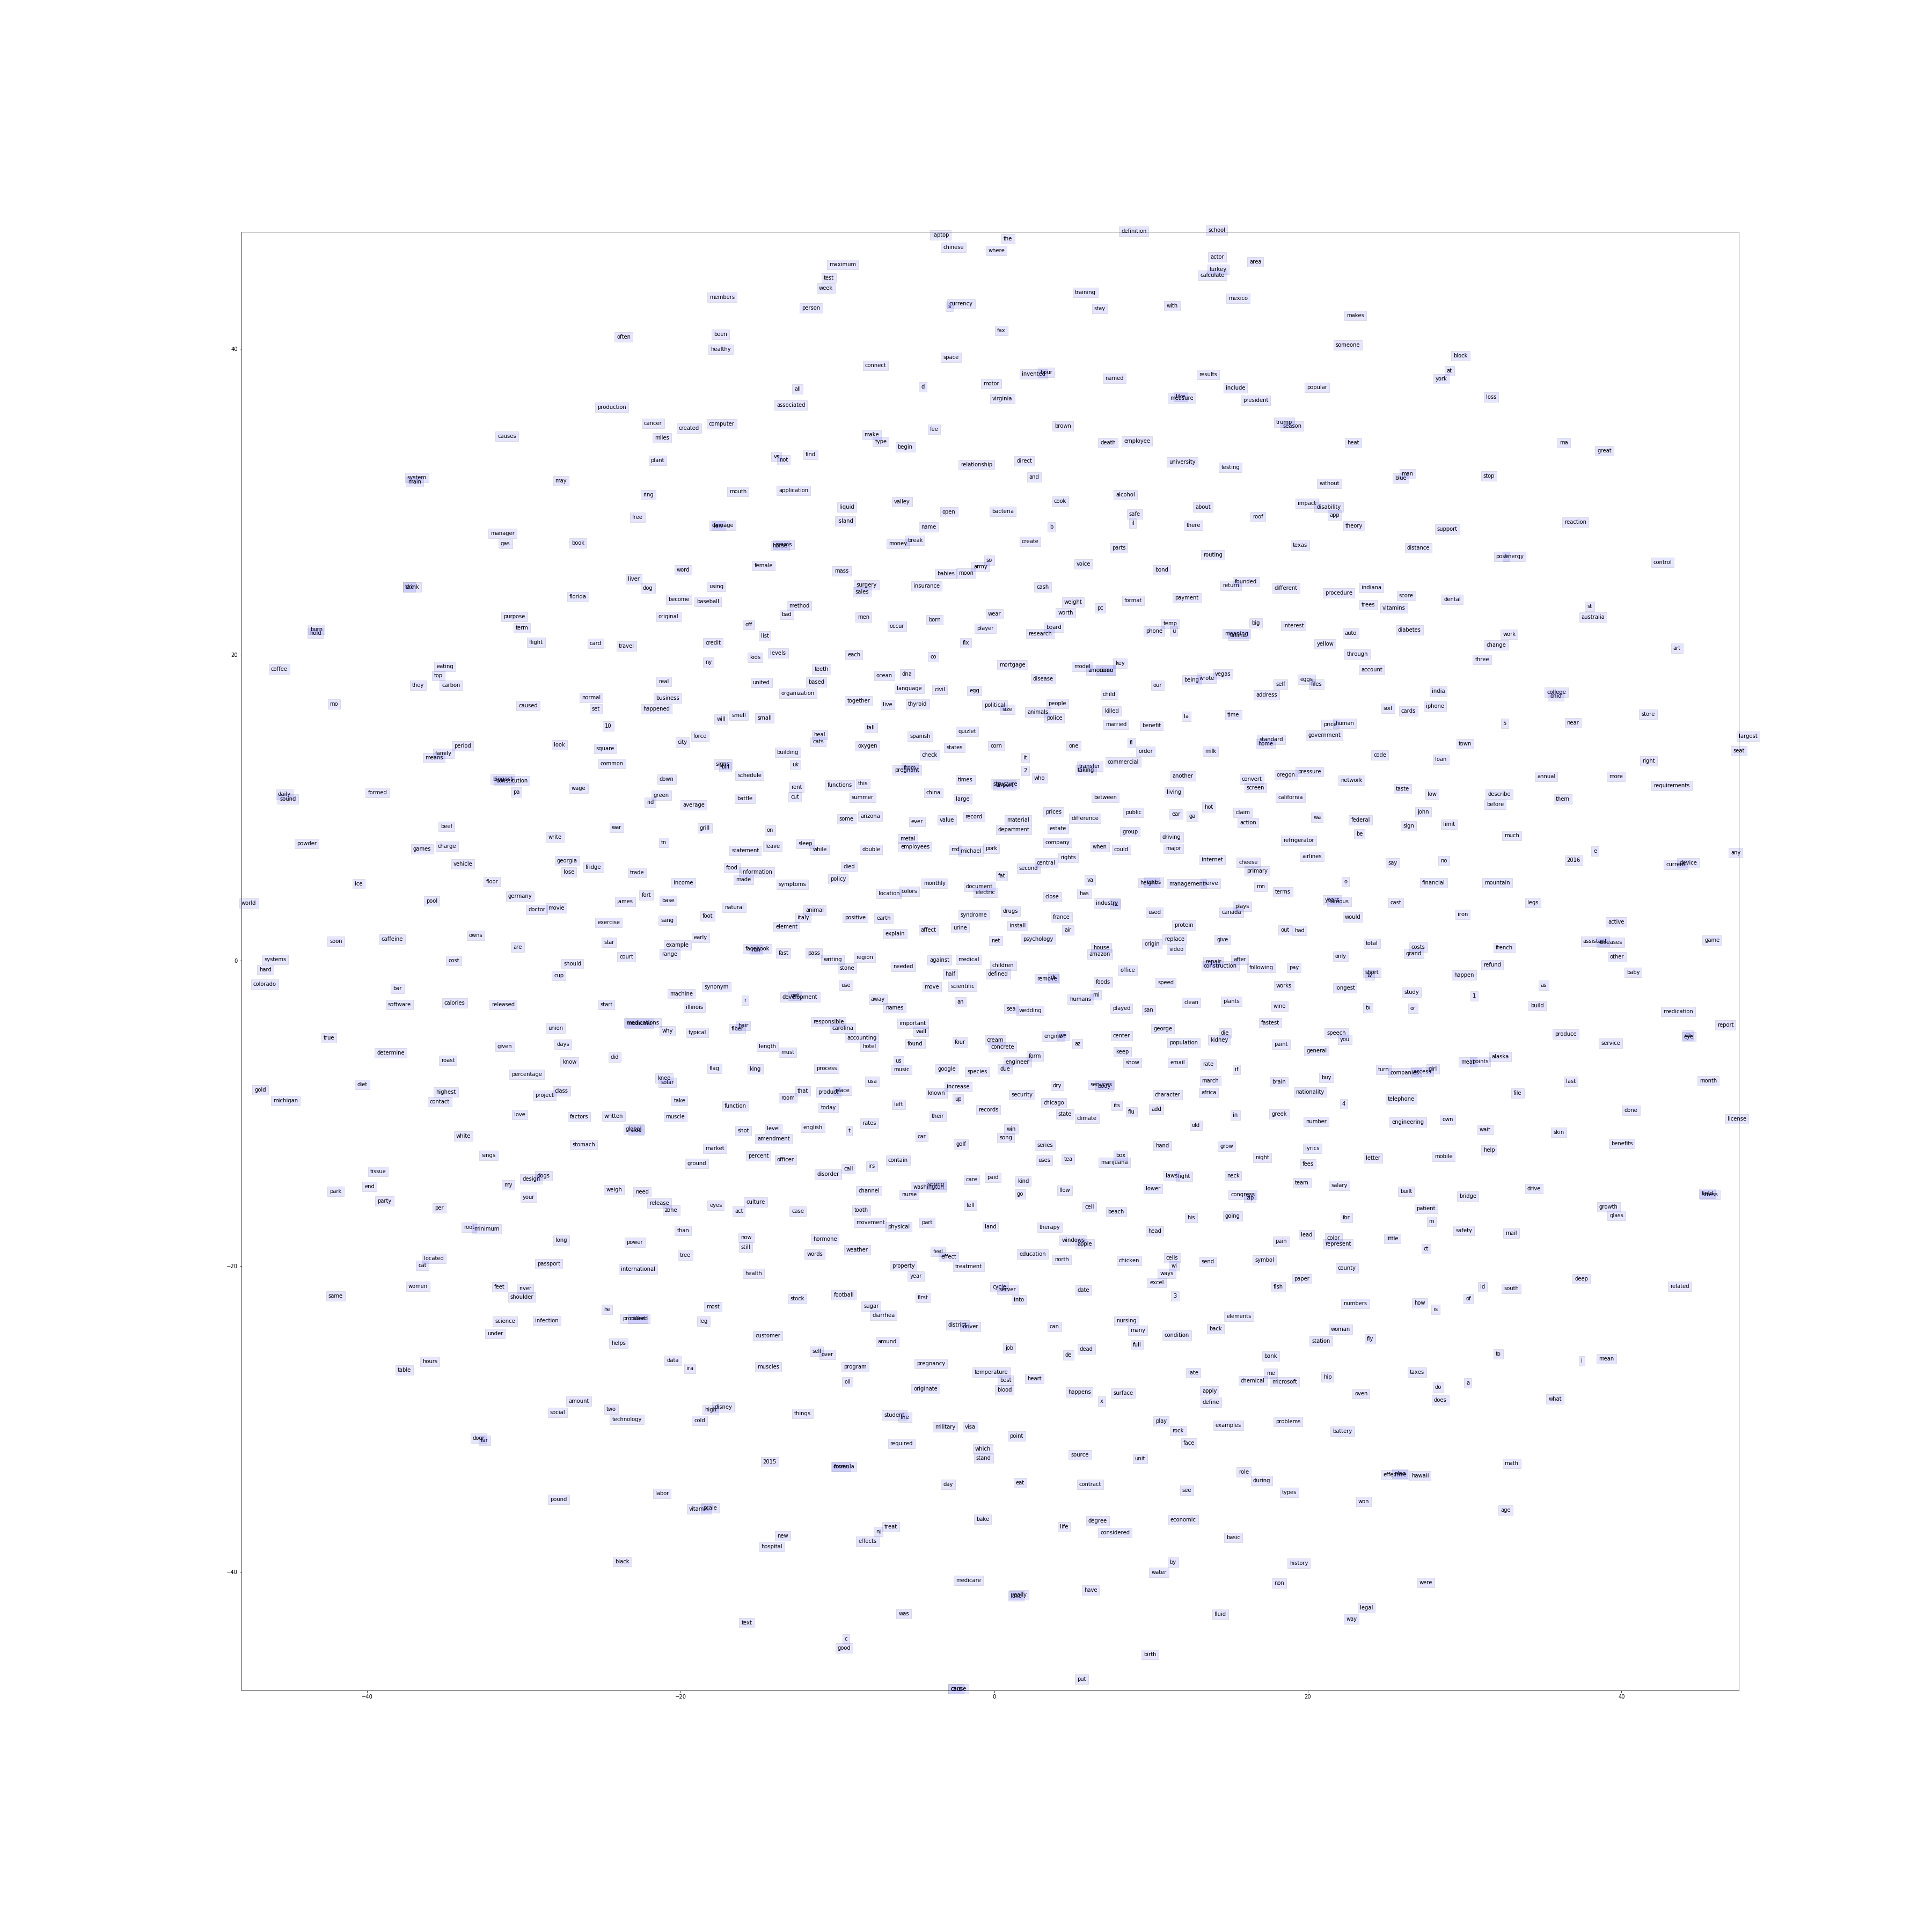

In [14]:
from IPython.display import Image
Image("TSNEMSMARCO.png")

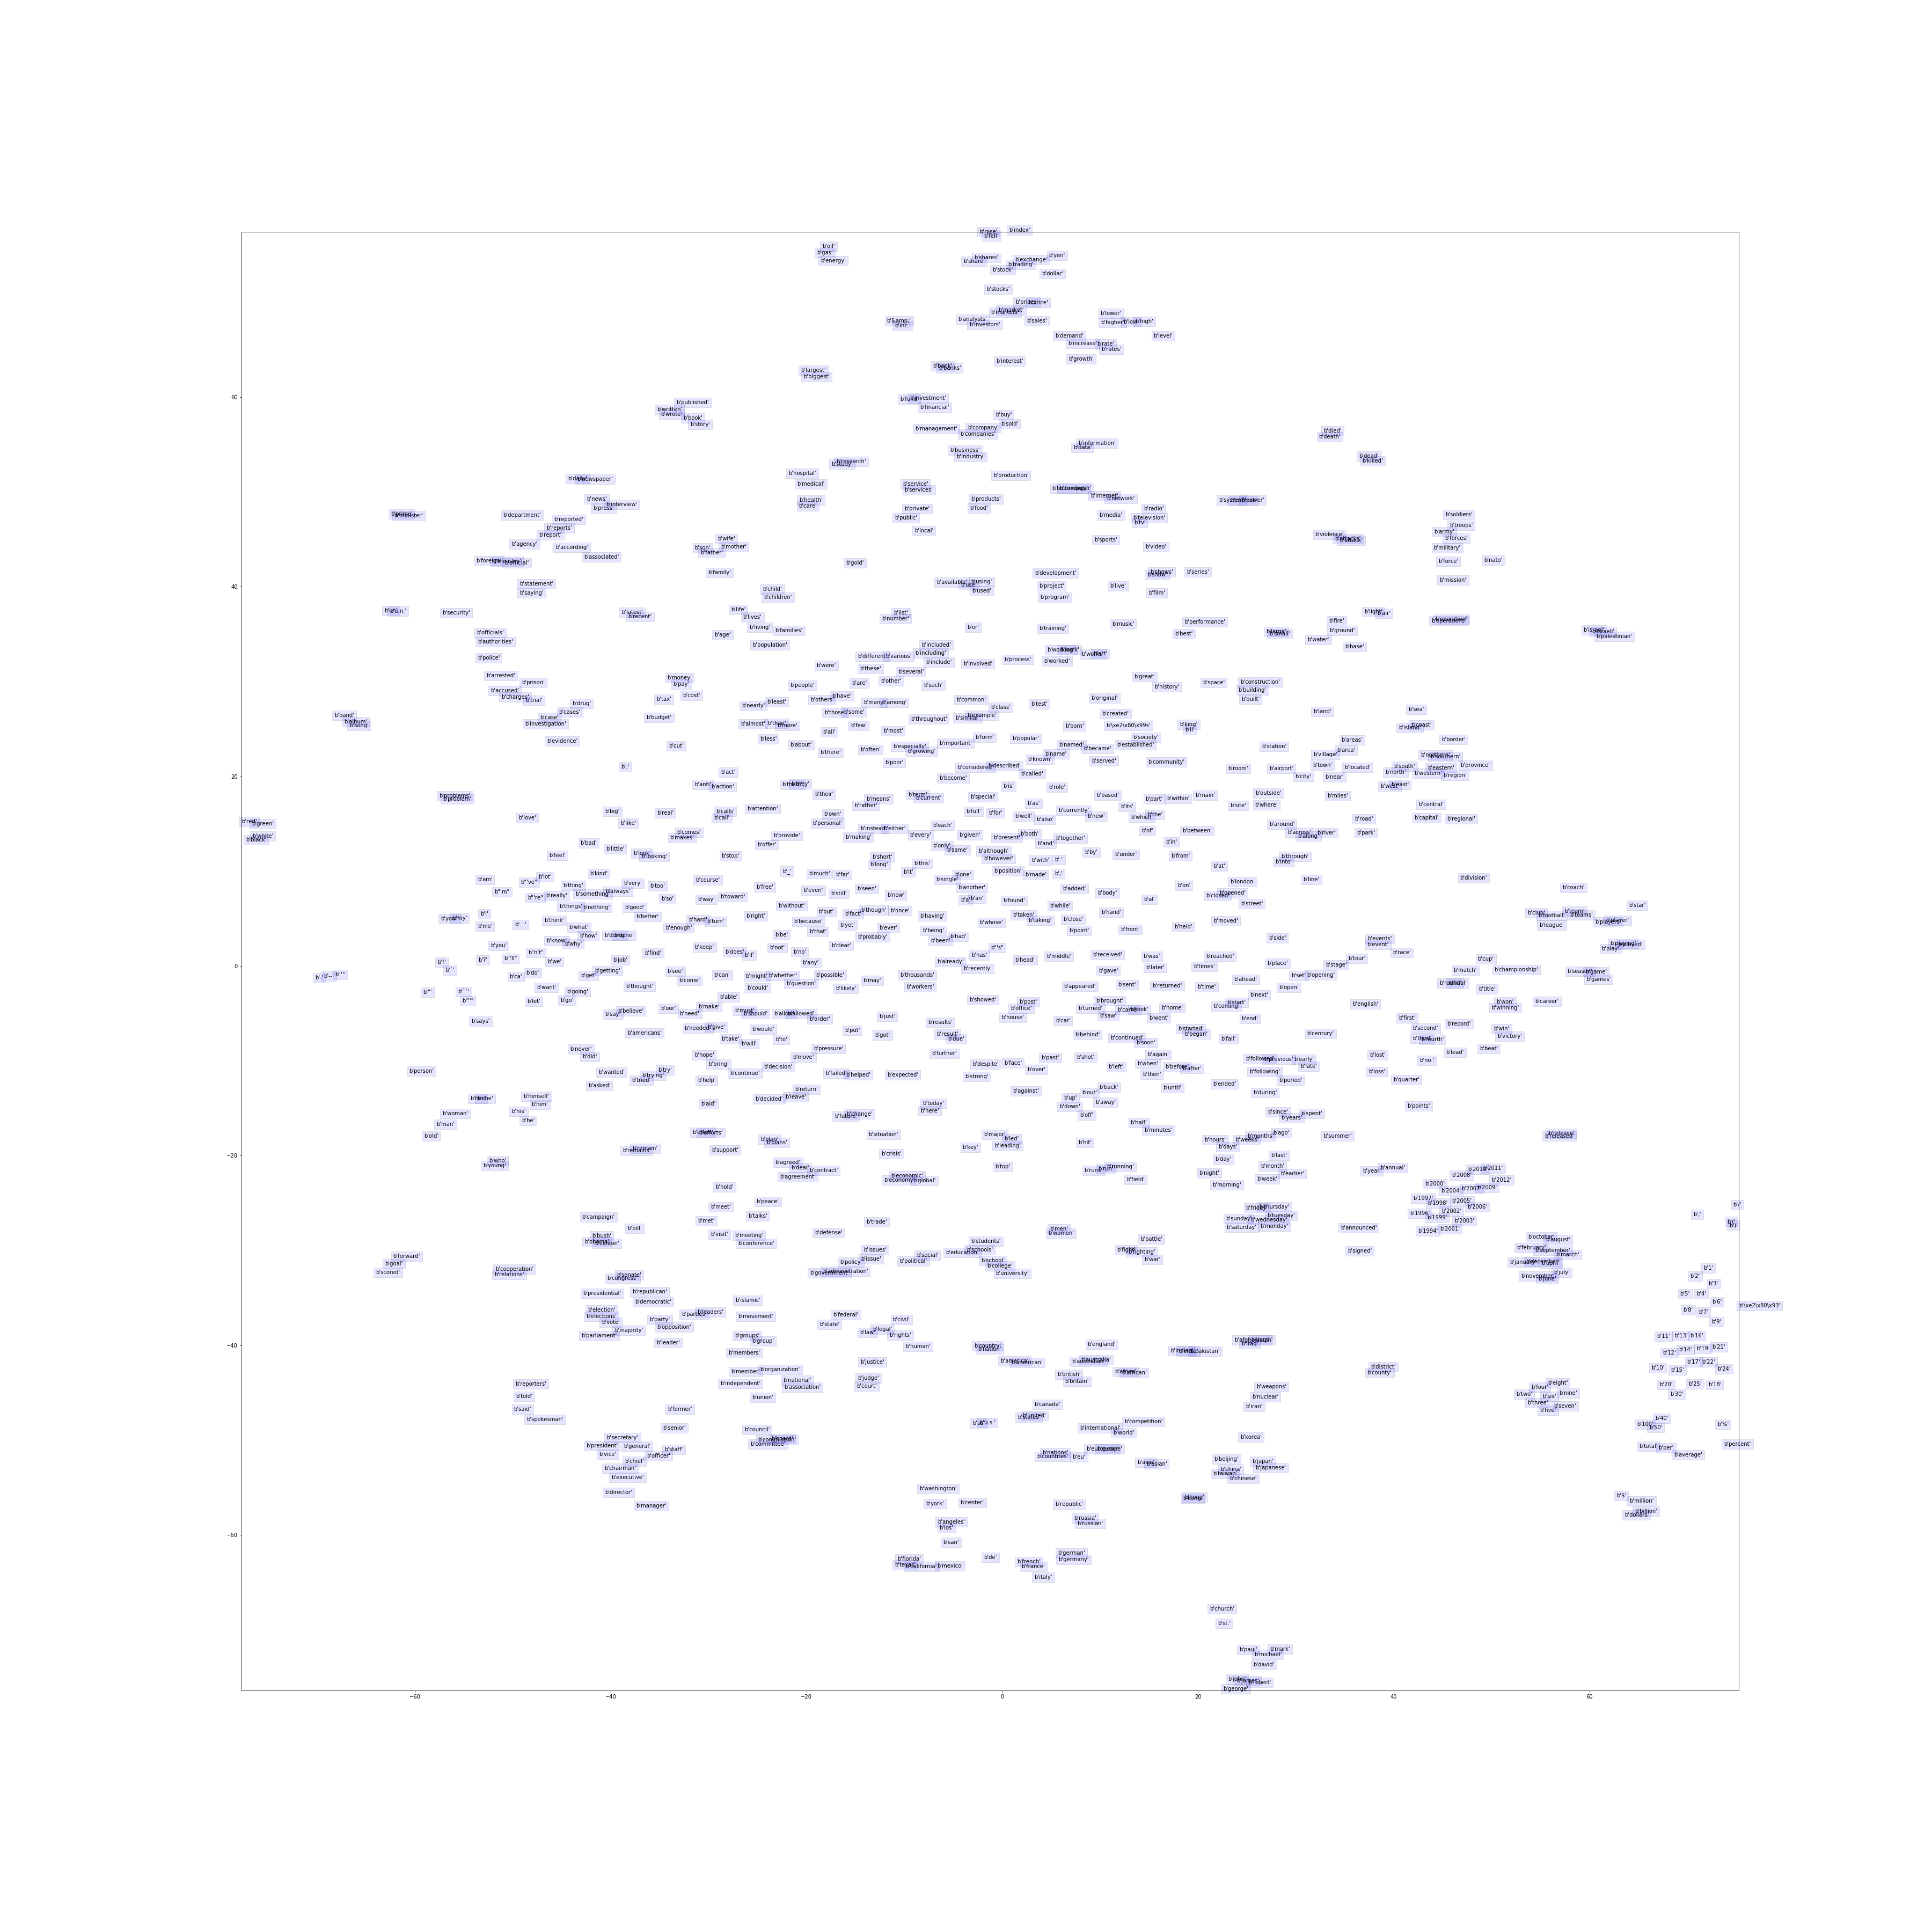

In [15]:
Image("TSNEGlove.png")

In [1]:
def annoyGlove():
    print_message("Starting Annoy Glove")
    i = 0
    word2idx={}
    idx2word = {}
    idx2vec = []
    with open('data/glove.6B.50d.txt','rb') as f:
        for l in f:
            l = l.strip().split()
            word2idx[l[0]] = i
            idx2word[i] = l[0]
            idx2vec.append(np.array(l[1:],dtype=float))
            i += 1
    idx2vec = np.array(idx2vec)
    t = AnnoyIndex(EMBEDDING_DIMENSION)
    for i in range(0,400000):
        t.add_item(i,idx2vec[i])
    t.build(100)
    #t.save('Glove.ann')
    x = np.zeros(EMBEDDING_DIMENSION)
    x = idx2vec[word2idx[b'the']] + idx2vec[word2idx[b'fall']] + idx2vec[word2idx[b'of']] + idx2vec[word2idx[b'the']] + idx2vec[word2idx[b'roman']] + + idx2vec[word2idx[b'empire']]
    neighbors = t.get_nns_by_vector(x,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to 'the fall of the roman empire' is {} with {} distance".format(idx2word[neighbors[0][i]], neighbors[1][i]))
    analogy = idx2vec[word2idx[b'king']]-idx2vec[word2idx[b'man']]+idx2vec[word2idx[b'woman']]
    neighbors = t.get_nns_by_vector(analogy,5,include_distances=True)
    for i in range(1,5):
        print_message("Closest item to 'king-man+woman' is {} with {} distance".format(idx2word[neighbors[0][i]], neighbors[1][i]))
    search_index = word2idx[b'cat']
    neighbors = t.get_nns_by_item(search_index,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to {} is {} with {} distance".format(idx2word[search_index], idx2word[neighbors[0][i]], neighbors[1][i] ))
    search_index = word2idx[b'war']
    neighbors = t.get_nns_by_item(search_index,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to {} is {} with {} distance".format(idx2word[search_index], idx2word[neighbors[0][i]], neighbors[1][i] ))
    print_message("war is {} far away from cat".format(t.get_distance(search_index,word2idx[b'cat'])))
    print_message("war is {} far away from battle".format(t.get_distance(search_index,word2idx[b'battle'])))

def annoyMSMARCO():
    print_message("Starting Annoy MSMARCO")
    word2idx = pickle.load(open('data/word2idx.txt', 'rb'))
    idx2word = pickle.load(open('data/idx2word.txt', 'rb'))
    idx2vec = pickle.load(open('data/idx2vec.txt', 'rb'))
    t = AnnoyIndex(EMBEDDING_DIMENSION)
    for i in range(0,VOCAB_SIZE-1):
        t.add_item(i,idx2vec[i])
    t.build(5000)
    #t.save('MSMARCO.ann')
    #t.load('MSMARCO.ann')
    search_index = word2idx['cat']
    neighbors = t.get_nns_by_item(search_index,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to {} is {} with {} distance".format(idx2word[search_index], idx2word[neighbors[0][i]], neighbors[1][i] ))
    search_index =  word2idx['war']
    neighbors = t.get_nns_by_item(search_index,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to {} is {} with {} distance".format(idx2word[search_index], idx2word[neighbors[0][i]], neighbors[1][i] ))
    print_message("war is {} far away from cat".format(t.get_distance(search_index,word2idx['cat'])))
    print_message("war is {} far away from battle".format(t.get_distance(search_index,word2idx['battle'])))
    sentence = 'the fall of roman empire'
    x = np.zeros(EMBEDDING_DIMENSION)
    for word in sentence.split():
        if word in word2idx:
            x += idx2vec[word2idx[word]]
    neighbors = t.get_nns_by_vector(x,5, include_distances=True)
    for i in range(1,5):
        print_message("Closest item to 'the fall of the roman empire' is {} with {} distance".format(idx2word[neighbors[0][i]], neighbors[1][i]))
    analogy = idx2vec[word2idx['king']]-idx2vec[word2idx['man']]+idx2vec[word2idx['woman']]
    t.get_nns_by_vector(analogy,5,include_distances=True)
    for i in range(1,5):
        print_message("Closest item to 'king-man+woman' is {} with {} distance".format(idx2word[neighbors[0][i]], neighbors[1][i]))

In [6]:
print("Now we can also use Annoy to compare and explore")
annoyMSMARCO()
annoyGlove()

Now we can also use Annoy to compare and explore
[Jan 15, 10:14:25] Starting Annoy MSMARCO
[Jan 15, 10:15:01] Closest item to cat is located with 1.0124261379241943 distance
[Jan 15, 10:15:01] Closest item to cat is ablation with 1.013336420059204 distance
[Jan 15, 10:15:01] Closest item to cat is tennis with 1.026106595993042 distance
[Jan 15, 10:15:01] Closest item to cat is associates with 1.0310022830963135 distance
[Jan 15, 10:15:01] Closest item to war is auckland with 0.9871744513511658 distance
[Jan 15, 10:15:01] Closest item to war is quiz with 1.0015816688537598 distance
[Jan 15, 10:15:01] Closest item to war is occurs with 1.0323231220245361 distance
[Jan 15, 10:15:01] Closest item to war is gamma with 1.0334335565567017 distance
[Jan 15, 10:15:01] war is 1.5001951456069946 far away from cat
[Jan 15, 10:15:01] war is 1.467017650604248 far away from battle
[Jan 15, 10:15:01] Closest item to 'the fall of the roman empire' is of with 0.8202840089797974 distance
[Jan 15, 10:15:0